In [1]:
import pandas as pd
import pyspark as spark
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
sc = spark.SparkContext()
sql = spark.SQLContext(sc)
from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from elephas.utils.rdd_utils import to_simple_rdd


Using TensorFlow backend.
/Users/rohitsuvarna/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Single Feature Sentiment Analysis

In [3]:
df = pd.read_csv('/Users/rohitsuvarna/Downloads/finalOutTwo.csv',header=None)
df.columns = ['DateTime','Sentiment_score','Price']
df.head()

,DateTime,Sentiment_score,Price
0,2017-10-31T05:00:00.000-04:00,0.092263,6158.76
1,2017-10-31T06:00:00.000-04:00,0.103770,6105.90
2,2017-10-31T07:00:00.000-04:00,0.111691,6094.36
3,2017-10-31T08:00:00.000-04:00,0.082134,6125.13
4,2017-10-31T09:00:00.000-04:00,0.089370,6165.00


In [130]:
#df = df.drop(df.columns[1],axis = 1) Uncomment this for pure time series analysis, without sentiment score

Plotting the input variables

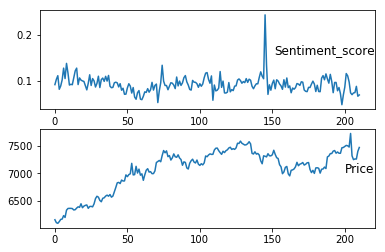

In [6]:
values = df.values
# specify columns to plot
groups = [ 1,2]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

Set index to datetime and change the order of columns

In [29]:
df.set_index('DateTime',inplace=True)  
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df


,Price,Sentiment_score
DateTime,,
2017-10-31T05:00:00.000-04:00,6158.76,0.092263
2017-10-31T06:00:00.000-04:00,6105.90,0.103770
2017-10-31T07:00:00.000-04:00,6094.36,0.111691
2017-10-31T08:00:00.000-04:00,6125.13,0.082134
2017-10-31T09:00:00.000-04:00,6165.00,0.089370
2017-10-31T10:00:00.000-04:00,6170.77,0.102672
2017-10-31T11:00:00.000-04:00,6233.74,0.128146
2017-10-31T12:00:00.000-04:00,6201.03,0.105498
2017-10-31T13:00:00.000-04:00,6332.34,0.138458


In [135]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

In [136]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Converts the original dataframe to a format which contains
    lag shifted values of inputs which can be used as input
    to the LSTM
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [137]:
n_hours = 3  #no of time lags
n_features = 1 #no of features
n_obs = n_hours*n_features

In [138]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var1(t-2),var1(t-1),var1(t)
3,0.039567,0.007090,0.000000,0.018905
4,0.007090,0.000000,0.018905,0.043401
5,0.000000,0.018905,0.043401,0.046946
6,0.018905,0.043401,0.046946,0.085634
7,0.043401,0.046946,0.085634,0.065537
8,0.046946,0.085634,0.065537,0.146213
9,0.085634,0.065537,0.146213,0.165131
10,0.065537,0.146213,0.165131,0.166378
11,0.146213,0.165131,0.166378,0.166144
12,0.165131,0.166378,0.166144,0.164307


In [34]:
reframed = reframed.drop(reframed.columns[-1], axis=1)
reframed.head()

,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
3,0.039567,0.223441,0.007090,0.282312,0.000000,0.322835,0.018905
4,0.007090,0.282312,0.000000,0.322835,0.018905,0.171625,0.043401
5,0.000000,0.322835,0.018905,0.171625,0.043401,0.208645,0.046946
6,0.018905,0.171625,0.043401,0.208645,0.046946,0.276694,0.085634
7,0.043401,0.208645,0.046946,0.276694,0.085634,0.407021,0.065537
8,0.046946,0.276694,0.085634,0.407021,0.065537,0.291150,0.146213
9,0.085634,0.407021,0.065537,0.291150,0.146213,0.459774,0.165131
10,0.065537,0.291150,0.146213,0.459774,0.165131,0.354060,0.166378
11,0.146213,0.459774,0.165131,0.354060,0.166378,0.218619,0.166144
12,0.165131,0.354060,0.166378,0.218619,0.166144,0.227313,0.164307


In [139]:
values = reframed.values
n_train_hours = 170
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(170, 4)

In [140]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [141]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(170, 3, 1) (170,) (38, 3, 1) (38,)


In [142]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history


Train on 170 samples, validate on 38 samples
Epoch 1/20
 - 1s - loss: 0.3689 - val_loss: 0.3847
Epoch 2/20
 - 0s - loss: 0.2041 - val_loss: 0.1684
Epoch 3/20
 - 0s - loss: 0.0876 - val_loss: 0.0603
Epoch 4/20
 - 0s - loss: 0.0884 - val_loss: 0.0589
Epoch 5/20
 - 0s - loss: 0.0830 - val_loss: 0.0573
Epoch 6/20
 - 0s - loss: 0.0767 - val_loss: 0.0550
Epoch 7/20
 - 0s - loss: 0.0688 - val_loss: 0.0541
Epoch 8/20
 - 0s - loss: 0.0635 - val_loss: 0.0522
Epoch 9/20
 - 0s - loss: 0.0568 - val_loss: 0.0504
Epoch 10/20
 - 0s - loss: 0.0506 - val_loss: 0.0497
Epoch 11/20
 - 0s - loss: 0.0449 - val_loss: 0.0486
Epoch 12/20
 - 0s - loss: 0.0420 - val_loss: 0.0476
Epoch 13/20
 - 0s - loss: 0.0375 - val_loss: 0.0472
Epoch 14/20
 - 0s - loss: 0.0356 - val_loss: 0.0465
Epoch 15/20
 - 0s - loss: 0.0344 - val_loss: 0.0463
Epoch 16/20
 - 0s - loss: 0.0337 - val_loss: 0.0459
Epoch 17/20
 - 0s - loss: 0.0334 - val_loss: 0.0464
Epoch 18/20
 - 0s - loss: 0.0337 - val_loss: 0.0460
Epoch 19/20
 - 0s - loss: 0.

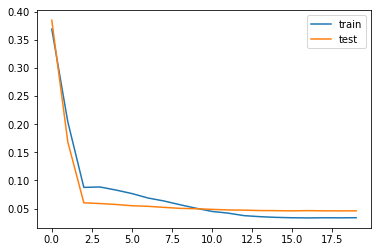

In [143]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [144]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 101.986


In [145]:
plt.plot(inv_y)
plt.plot(inv_yhat)

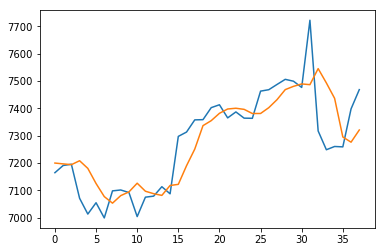

In [146]:
plt.show()

In [43]:
inv_y = np.insert(inv_y,0,7000)

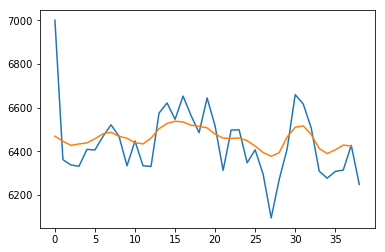

In [44]:
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()

# Elephas Implementation

In [18]:
spark_df = sql.createDataFrame(df)
CleanDF = spark_df.withColumn("DateTime_casted",spark_df['DateTime'].cast(TimestampType()))
FinalDf = CleanDF.selectExpr("DateTime_casted as Date_Time", "Sentiment_score",'Price AS Price1')

In [ ]:
from keras.engine.training import _slice_arrays

In [ ]:
FinalDf.show()

In [ ]:
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window
for i in range(2,3):
    col1 = "Price%d"%(i-1)
    col2 = "Price%d"%i
    w = Window().partitionBy().orderBy(col("Date_Time"))
    FinalDf=FinalDf.select("*", lag(col1).over(w).alias(col2)).na.drop()
    FinalDf.show()

In [ ]:
FinalDf = FinalDf.selectExpr('Date_Time','Sentiment_score','Price2 as Input_price','Price1 as Price')

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

In [16]:
rdd = to_simple_rdd(sc, train_X, train_y)

In [17]:
rdd.count()

170

In [18]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
#from keras.models import model_from_yaml,slice_X


In [20]:
from keras.utils import np_utils
from elephas.spark_model import SparkModel
from elephas.utils.rdd_utils import to_simple_rdd
from elephas import optimizers as elephas_optimizers

In [21]:
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [22]:
adam = elephas_optimizers.Adam()

In [1]:
spark_model = SparkModel(sc,model, optimizer=adam, frequency='epoch', num_workers=2)
spark_model.train(rdd, nb_epoch=50, batch_size=4, verbose=2, validation_split=0.1)

## Multifeature Sentiment Analysis

In [96]:
df1 = pd.read_csv('/Users/rohitsuvarna/Downloads/features.csv',header=None)
df1.columns = ['DateTime','Negative','Neutral','Positive','Compound','Price']
df1.head()

,DateTime,Negative,Neutral,Positive,Compound,Price
0,2017-10-31T05:00:00.000-04:00,0.032105,0.888699,0.076390,0.095283,6158.76
1,2017-10-31T06:00:00.000-04:00,0.035658,0.862046,0.101670,0.130807,6105.90
2,2017-10-31T07:00:00.000-04:00,0.034356,0.864839,0.099413,0.130343,6094.36
3,2017-10-31T08:00:00.000-04:00,0.036202,0.879061,0.084736,0.110576,6125.13
4,2017-10-31T09:00:00.000-04:00,0.043838,0.862753,0.092850,0.108861,6165.00


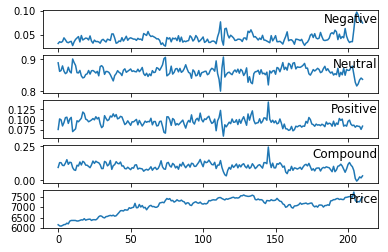

In [97]:
values = df1.values
# specify columns to plot
groups = [ 1,2,3,4,5]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df1.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [98]:
df1.set_index('DateTime',inplace=True)

In [100]:
cols = df1.columns.tolist()
cols = cols[-1:] + cols[:-1]
df1 = df1[cols]
df1.head()

,Price,Negative,Neutral,Positive,Compound
DateTime,,,,,
2017-10-31T05:00:00.000-04:00,6158.76,0.032105,0.888699,0.076390,0.095283
2017-10-31T06:00:00.000-04:00,6105.90,0.035658,0.862046,0.101670,0.130807
2017-10-31T07:00:00.000-04:00,6094.36,0.034356,0.864839,0.099413,0.130343
2017-10-31T08:00:00.000-04:00,6125.13,0.036202,0.879061,0.084736,0.110576
2017-10-31T09:00:00.000-04:00,6165.00,0.043838,0.862753,0.092850,0.108861


In [101]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df1.values)

In [102]:
n_hours = 3
n_features = 5
n_obs = n_hours*n_features

In [103]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.039567,0.078779,0.831199,0.195812,0.401475,0.007090,0.128849,0.579299,0.505289,0.542609,0.000000,0.110492,0.605697,0.477654,0.540763,0.018905,0.136519,0.740108,0.297985,0.462231
4,0.007090,0.128849,0.579299,0.505289,0.542609,0.000000,0.110492,0.605697,0.477654,0.540763,0.018905,0.136519,0.740108,0.297985,0.462231,0.043401,0.244122,0.585976,0.397319,0.455419
5,0.000000,0.110492,0.605697,0.477654,0.540763,0.018905,0.136519,0.740108,0.297985,0.462231,0.043401,0.244122,0.585976,0.397319,0.455419,0.046946,0.186121,0.513127,0.542100,0.528573
6,0.018905,0.136519,0.740108,0.297985,0.462231,0.043401,0.244122,0.585976,0.397319,0.455419,0.046946,0.186121,0.513127,0.542100,0.528573,0.085634,0.117236,0.544642,0.555482,0.628997
7,0.043401,0.244122,0.585976,0.397319,0.455419,0.046946,0.186121,0.513127,0.542100,0.528573,0.085634,0.117236,0.544642,0.555482,0.628997,0.065537,0.100541,0.701571,0.373207,0.492066
8,0.046946,0.186121,0.513127,0.542100,0.528573,0.085634,0.117236,0.544642,0.555482,0.628997,0.065537,0.100541,0.701571,0.373207,0.492066,0.146213,0.126593,0.578442,0.500330,0.552681
9,0.085634,0.117236,0.544642,0.555482,0.628997,0.065537,0.100541,0.701571,0.373207,0.492066,0.146213,0.126593,0.578442,0.500330,0.552681,0.165131,0.141180,0.532970,0.549913,0.543096
10,0.065537,0.100541,0.701571,0.373207,0.492066,0.146213,0.126593,0.578442,0.500330,0.552681,0.165131,0.141180,0.532970,0.549913,0.543096,0.166378,0.016336,0.942586,0.132895,0.395744
11,0.146213,0.126593,0.578442,0.500330,0.552681,0.165131,0.141180,0.532970,0.549913,0.543096,0.166378,0.016336,0.942586,0.132895,0.395744,0.166144,0.124761,0.837867,0.171567,0.329644
12,0.165131,0.141180,0.532970,0.549913,0.543096,0.166378,0.016336,0.942586,0.132895,0.395744,0.166144,0.124761,0.837867,0.171567,0.329644,0.164307,0.198284,0.755304,0.213454,0.314862


In [105]:
reframed = reframed.drop(reframed.columns[-4:], axis=1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
3,0.039567,0.078779,0.831199,0.195812,0.401475,0.007090,0.128849,0.579299,0.505289,0.542609,0.000000,0.110492,0.605697,0.477654,0.540763,0.018905
4,0.007090,0.128849,0.579299,0.505289,0.542609,0.000000,0.110492,0.605697,0.477654,0.540763,0.018905,0.136519,0.740108,0.297985,0.462231,0.043401
5,0.000000,0.110492,0.605697,0.477654,0.540763,0.018905,0.136519,0.740108,0.297985,0.462231,0.043401,0.244122,0.585976,0.397319,0.455419,0.046946
6,0.018905,0.136519,0.740108,0.297985,0.462231,0.043401,0.244122,0.585976,0.397319,0.455419,0.046946,0.186121,0.513127,0.542100,0.528573,0.085634
7,0.043401,0.244122,0.585976,0.397319,0.455419,0.046946,0.186121,0.513127,0.542100,0.528573,0.085634,0.117236,0.544642,0.555482,0.628997,0.065537
8,0.046946,0.186121,0.513127,0.542100,0.528573,0.085634,0.117236,0.544642,0.555482,0.628997,0.065537,0.100541,0.701571,0.373207,0.492066,0.146213
9,0.085634,0.117236,0.544642,0.555482,0.628997,0.065537,0.100541,0.701571,0.373207,0.492066,0.146213,0.126593,0.578442,0.500330,0.552681,0.165131
10,0.065537,0.100541,0.701571,0.373207,0.492066,0.146213,0.126593,0.578442,0.500330,0.552681,0.165131,0.141180,0.532970,0.549913,0.543096,0.166378
11,0.146213,0.126593,0.578442,0.500330,0.552681,0.165131,0.141180,0.532970,0.549913,0.543096,0.166378,0.016336,0.942586,0.132895,0.395744,0.166144
12,0.165131,0.141180,0.532970,0.549913,0.543096,0.166378,0.016336,0.942586,0.132895,0.395744,0.166144,0.124761,0.837867,0.171567,0.329644,0.164307


In [89]:
values = reframed.values
n_train_hours = 170
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(170, 16)

In [106]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [107]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(170, 3, 5) (170,) (38, 3, 5) (38,)


In [108]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

Train on 170 samples, validate on 38 samples
Epoch 1/20
 - 1s - loss: 0.0688 - val_loss: 0.1399
Epoch 2/20
 - 0s - loss: 0.0660 - val_loss: 0.1376
Epoch 3/20
 - 0s - loss: 0.0631 - val_loss: 0.1317
Epoch 4/20
 - 0s - loss: 0.0609 - val_loss: 0.1252
Epoch 5/20
 - 0s - loss: 0.0585 - val_loss: 0.1208
Epoch 6/20
 - 0s - loss: 0.0566 - val_loss: 0.1157
Epoch 7/20
 - 0s - loss: 0.0545 - val_loss: 0.1100
Epoch 8/20
 - 0s - loss: 0.0517 - val_loss: 0.1066
Epoch 9/20
 - 0s - loss: 0.0496 - val_loss: 0.1011
Epoch 10/20
 - 0s - loss: 0.0477 - val_loss: 0.0964
Epoch 11/20
 - 0s - loss: 0.0454 - val_loss: 0.0897
Epoch 12/20
 - 0s - loss: 0.0437 - val_loss: 0.0840
Epoch 13/20
 - 0s - loss: 0.0410 - val_loss: 0.0795
Epoch 14/20
 - 0s - loss: 0.0385 - val_loss: 0.0735
Epoch 15/20
 - 0s - loss: 0.0363 - val_loss: 0.0701
Epoch 16/20
 - 0s - loss: 0.0339 - val_loss: 0.0642
Epoch 17/20
 - 0s - loss: 0.0320 - val_loss: 0.0605
Epoch 18/20
 - 0s - loss: 0.0303 - val_loss: 0.0559
Epoch 19/20
 - 0s - loss: 0.

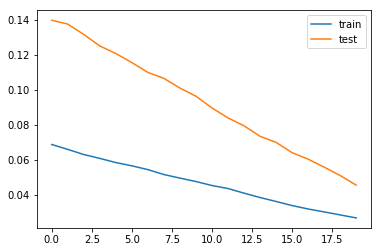

In [109]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [110]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 110.902


In [111]:
plt.plot(inv_y)
plt.plot(inv_yhat)

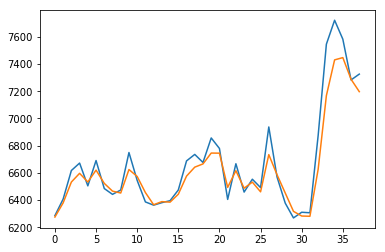

In [112]:
plt.show()

In [115]:
inv_yhat.shape

(38,)

In [120]:
df_sol = pd.DataFrame({'forecast':inv_yhat,'actual':inv_y})
df_sol.to_csv('Predictions_nosent.csv')